# Single Image analysis pipeline: assess nuclear signal intensity (HCR, PLA)

Written by JA Zagalak (julian.zagalak@kcl.ac.uk):
---
*adapted from:  Introduction to Image Analysis Workshop*
*by Stefania Marcotti, KCL*


*CC-BY-SA-4.0 license: creativecommons.org/licenses/by-sa/4.0/*

---

### Import libraries

In [34]:
import numpy as np

import skimage as ski
from skimage import io
from skimage import filters, measure, morphology, segmentation
from skimage.io import imread, imshow

from skimage.morphology import erosion, dilation
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import colormaps
import pandas as pd

### Open image

In [10]:
# read .tif file
im_read = io.imread('../../Data/HCR1/Well2/Well2 RR BB7 M3_1_MMStack_Pos0.ome.tif')

In [11]:
# print image type
print('Image type:', type(im_read))

Image type: <class 'numpy.ndarray'>


Image dimensions: (2, 1200, 1920)


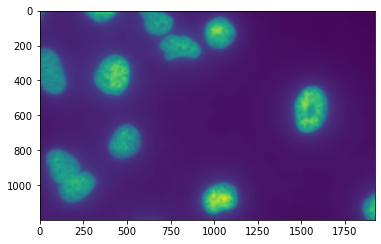

In [12]:
# print image dimensions
print('Image dimensions:', im_read.shape)
imgplot = plt.imshow(im_read[0,])

In [13]:
# rearrange channels if needed to match c,y,x notation
im_all = np.transpose(im_read, (2, 0, 1))

#if not keep 
im_all = im_read
print('New image dimensions:', im_all.shape)

New image dimensions: (2, 1200, 1920)


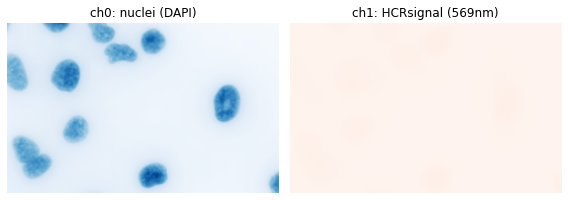

In [14]:
# display both channels 
fig, axs = plt.subplots(1, 2, figsize=(8,6))

axs[0].imshow(im_all[0,], cmap='Blues')
axs[0].set_title('ch0: nuclei (DAPI)')
axs[0].axis('off')

axs[1].imshow(im_all[1,], cmap='Reds')
axs[1].set_title('ch1: HCRsignal (569nm)')
axs[1].axis('off')

plt.tight_layout()

In [15]:
# select the channel containing the nuclei
im = im_all[0,]
im_2 = im_all[1,]

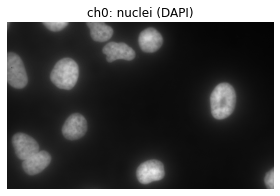

In [16]:
# display image
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(im, cmap='gray')
ax.set_title('ch0: nuclei (DAPI)')
ax.axis('off')
plt.tight_layout()

### Use filters to suppress noise

In [17]:
# Gaussian blur
im_gauss = filters.gaussian(im, sigma=1)

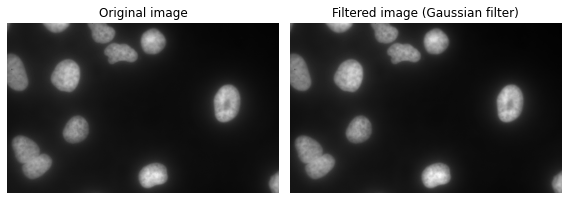

In [18]:
# display original image next to filtered one
fig, axs = plt.subplots(1, 2, figsize=(8,6))

axs[0].imshow(im, cmap='gray')
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(im_gauss, cmap='gray')
axs[1].set_title('Filtered image (Gaussian filter)')
axs[1].axis('off')

plt.tight_layout()

### Segment images using grey level thresholding

Try different thresholding methods

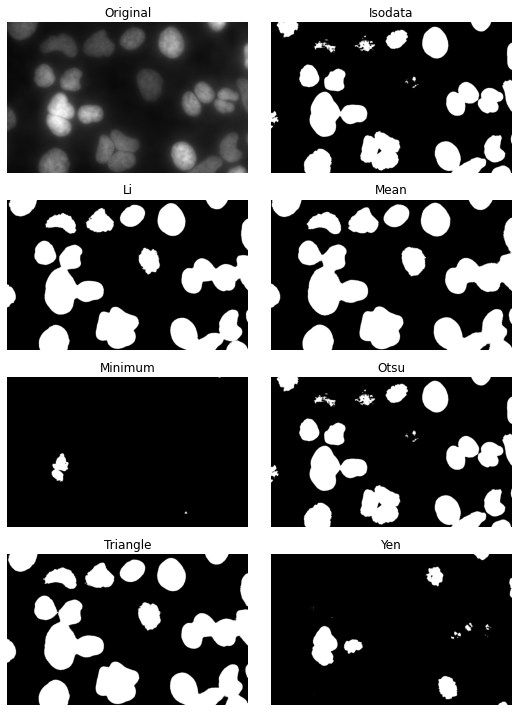

In [16]:
# display various options for gray level thresholding
fig, ax = filters.try_all_threshold(im_gauss, figsize=(8,10), verbose=False)
plt.tight_layout()

In [19]:
# Otsu thresholding performs quite well 
thresh = filters.threshold_otsu(im_gauss)
im_thresh = im_gauss > thresh
im_thresh = ndi.binary_fill_holes(im_thresh)


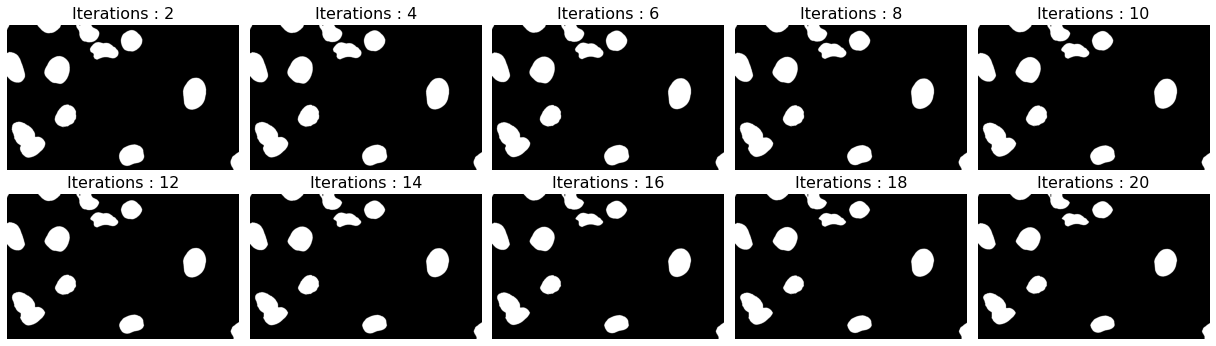

In [20]:
#build kernel for morphology erosion
cross = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]])
h_line = np.array([[0,0,0],
                  [1,1,1],
                  [0,0,0]])
v_line = np.array([[0,1,0],
                  [0,1,0],
                  [0,1,0]])

def multi_erosion(image, kernel, iterations):
    for i in range(iterations):
        image = erosion(image, kernel)
    return image

ites = [2,4,6,8,10,12,14,16,18,20]
fig, ax = plt.subplots(2, 5, figsize=(17, 5))
for n, ax in enumerate(ax.flatten()):
    ax.set_title(f'Iterations : {ites[n]}', fontsize = 16)
    new_circle = multi_erosion(im_thresh, v_line, ites[n])
    ax.imshow(new_circle, cmap = 'gray');
    ax.axis('off')
fig.tight_layout()

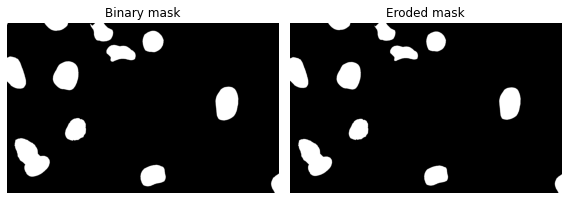

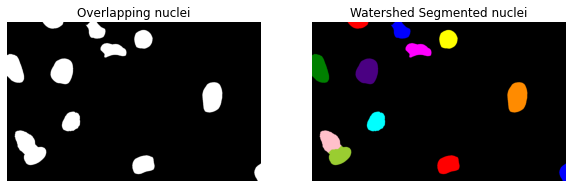

In [24]:
#Optionally erode mask if it helps segmenting the cells properly (chose n iterations based on above output)
im_erode = multi_erosion(im_thresh, cross, 5)

# display the binary mask
fig, ax = plt.subplots(1,2, figsize=(8,6))
ax[0].imshow(im_thresh, cmap='gray')
ax[0].set_title('Binary mask')
ax[0].axis('off')

ax[1].imshow(im_erode, cmap='gray')
ax[1].set_title('Eroded mask')
ax[1].axis('off')

plt.tight_layout()

#or try watershed function to divide overlapping nuclear signal, empirical variable min distance in pxl

im_thresh = im_erode
min_dis = 60

distance = ndi.distance_transform_edt(im_thresh)

local_max_coords = ski.feature.peak_local_max(
    distance, min_distance= min_dis, exclude_border=False
)
local_max_mask = np.zeros(distance.shape, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True
markers = ski.measure.label(local_max_mask)

segmented_cells = ski.segmentation.watershed(-distance, markers, mask=im_thresh)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(im_thresh, cmap='gray')
ax[0].set_title('Overlapping nuclei')
ax[0].set_axis_off()
ax[1].imshow(ski.color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title('Watershed Segmented nuclei')
ax[1].set_axis_off()
plt.show()


### Count objects


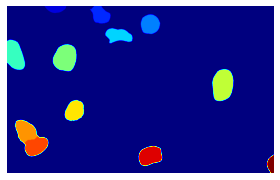

In [25]:
# label objects and visualise the result
labels = measure.label(segmented_cells)

fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(labels, cmap='jet')
ax.axis('off')
plt.tight_layout()


In [26]:
# count the objects - find the maximum integer assigned to a label!
print('There are', labels.max(), 'objects in the image')

There are 12 objects in the image


### Perform basic morphological quantification

In [27]:
# measure properties
props = measure.regionprops_table(labels, im_2, properties=['area', 'centroid', 'eccentricity','extent','intensity_mean','label'])
props_df = pd.DataFrame(props)

props_df.head(5)

,area,centroid-0,centroid-1,eccentricity,extent,intensity_mean,label
0,5737,20.167683,349.941956,0.936000,0.730828,85.683110,1
1,12819,63.884858,671.569857,0.686732,0.678254,85.685779,2
2,15580,131.041399,1029.276958,0.256247,0.794939,97.501027,3
3,14970,211.385170,801.063260,0.877993,0.700711,88.197862,4
4,21593,355.173482,57.590747,0.857207,0.764327,79.994628,5


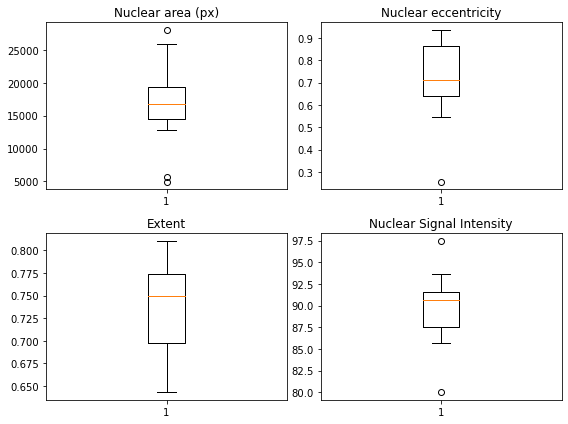

In [33]:
# display some results
fig, axs = plt.subplots(2, 2, figsize=(8,6))

axs[0,0].boxplot(props_df['area'])
axs[0,0].set_title('Nuclear area (px)')

axs[0,1].boxplot(props_df['eccentricity'])
axs[0,1].set_title('Nuclear eccentricity')

axs[1,0].boxplot(props_df['extent'])
axs[1,0].set_title('Extent')

axs[1,1].boxplot(props_df['intensity_mean'])
axs[1,1].set_title('Nuclear Signal Intensity')


plt.tight_layout()